# Proyecto de predicciones para CS2

Importamos las librerías que utilizaremos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Limpieza de datos

Cargamos los datos extraidos previamente con web scraping y la clase ``HltvScraper``.

In [2]:
data = "WebScraping/Data/"

df_matches = pd.read_csv(data + "matches_played_by_team.csv")
df_players = pd.read_csv(data + "players_stats.csv")
df_teams   = pd.read_csv(data + "teams_stats_by_map.csv")
df_pistols = pd.read_csv(data + "pistols.csv")
df_ftu     = pd.read_csv(data + "ftu.csv")

Definimos la siguiente función que nos ayudará a limpiar los datos.

In [3]:
def dividir_columna(df: pd.DataFrame, column: str, sep: str, new_names: list) -> pd.DataFrame:
    position = df.columns.get_loc(column)
    columns_created = df.pop(column).str.split(sep, expand=True)
    columns_created.columns = new_names

    for i, col in enumerate(columns_created.columns):
        df.insert(position + i, col, columns_created[col])

    return df

## Limpieza de ``df_matches``

In [4]:
df_matches.head()

,Date,Event,Opponent,Map,Result,W/L,Group,Team
0,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Ancient,13 - 2,W,europa_1,Natus Vincere
1,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Nuke,13 - 10,W,europa_1,Natus Vincere
2,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Inferno,7 - 13,L,europa_1,Natus Vincere
3,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Dust2,8 - 13,L,europa_1,Natus Vincere
4,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Mirage,13 - 4,W,europa_1,Natus Vincere


In [5]:
df_matches.dtypes

Date        object
Event       object
Opponent    object
Map         object
Result      object
W/L         object
Group       object
Team        object
dtype: object

In [6]:
df_matches = dividir_columna(df_matches, "Result", " - ", ["Rounds won", "Rounds lost"])



columns_to_int = ["Rounds won", "Rounds lost"]
columns_to_category = ["Map", "W/L", "Group", "Team"]

for col in columns_to_int:
    df_matches[col] = df_matches[col].astype(int)

for col in columns_to_category:
    df_matches[col] = df_matches[col].astype("category")

df_matches["Date"] = df_matches["Date"].astype("datetime64[ns]")

In [7]:
df_matches = df_matches.drop(["Event", "Group"], axis=1)
col = df_matches.pop("Team")
df_matches.insert(1, "Team", col)
df_matches

,Date,Team,Opponent,Map,Rounds won,Rounds lost,W/L
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W
...,...,...,...,...,...,...,...
11455,2024-08-28,DRILLAS,Al-Ittihad,Mirage,13,1,W
11456,2024-08-28,DRILLAS,JiJieHao,Dust2,8,13,L
11457,2024-08-22,DRILLAS,Superfkrs,Anubis,8,13,L
11458,2024-08-21,DRILLAS,Unlucky Much?,Mirage,13,7,W


In [8]:
df_matches = df_matches[df_matches["Map"] != "Overpass"]

teams = df_teams["Team"].unique()
df_matches = df_matches[df_matches["Opponent"].isin(teams)]

In [9]:
df_matches = df_matches.rename({
    "Map": "Map Name",
    "Rounds won": "Result RW",
    "Rounds lost": "Result RL"
}, axis=1)

df_matches["Result Diff"] = df_matches["Result RW"] - df_matches["Result RL"]
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,W,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,L,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,L,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,W,2


In [10]:
df_matches['W/L']= pd.Categorical(df_matches['W/L']).codes
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,1,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,0,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,0,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,1,2


## Limpieza de ``df_players``

In [11]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [12]:
df_players.dtypes

Kills                                  int64
Deaths                                 int64
Kill / Death                         float64
Kill / Round                         float64
Rounds with kills                      int64
Kill - Death difference                int64
Total opening kills                    int64
Total opening deaths                   int64
Opening kill ratio                   float64
Opening kill rating                  float64
Team win percent after first kill     object
First kill in won rounds              object
0 kill rounds                          int64
1 kill rounds                          int64
2 kill rounds                          int64
3 kill rounds                          int64
4 kill rounds                          int64
5 kill rounds                          int64
Rifle kills                            int64
Sniper kills                           int64
SMG kills                              int64
Pistol kills                           int64
Grenade   

In [13]:
columns_to_float = ["Team win percent after first kill", "First kill in won rounds"]
columns_to_category = ["Player", "Group", "Team", "Map Name"]

for col in columns_to_float:
    df_players[col] = df_players[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_players[col] = df_players[col].astype("category")

In [14]:
df_players.isna().sum()

Kills                                0
Deaths                               0
Kill / Death                         0
Kill / Round                         0
Rounds with kills                    0
Kill - Death difference              0
Total opening kills                  0
Total opening deaths                 0
Opening kill ratio                   0
Opening kill rating                  0
Team win percent after first kill    2
First kill in won rounds             0
0 kill rounds                        0
1 kill rounds                        0
2 kill rounds                        0
3 kill rounds                        0
4 kill rounds                        0
5 kill rounds                        0
Rifle kills                          0
Sniper kills                         0
SMG kills                            0
Pistol kills                         0
Grenade                              0
Other                                0
Player                               0
Group                    

In [15]:
df_players["Team win percent after first kill"] = df_players["Team win percent after first kill"].fillna(0)

In [16]:
df_dups = df_players.iloc[:, :-4]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups


,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,2 kill rounds,3 kill rounds,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other
5,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1841,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1865,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1867,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_players = df_players.drop(index=df_dups.index)

In [18]:
df_players.shape

(1786, 28)

## Limpieza de ``df_teams``

In [19]:
df_teams.head()

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent,Group,Team,Map Name
0,34,22 / 0 / 12,724,390,64.7%,68,38,55.9%,55.1%,52.6%,europa_1,Natus Vincere,Ancient
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%,europa_1,Vitality,Ancient
2,23,14 / 0 / 9,513,280,60.9%,46,28,60.9%,56.4%,52.9%,europa_1,MOUZ,Ancient
3,33,21 / 0 / 12,752,409,63.6%,66,40,60.6%,53.8%,54.9%,europa_1,FaZe,Ancient
4,22,8 / 0 / 14,479,224,36.4%,44,23,52.3%,50.4%,42.3%,europa_1,Falcons,Ancient


In [20]:
df_dups = df_teams.iloc[:, :-3]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
58,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
77,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
103,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
183,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
185,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
194,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
213,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
222,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
238,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%


In [21]:
df_teams = df_teams.drop(index=df_dups.index)

In [22]:
df_teams = dividir_columna(df_teams, "Wins / draws / losses", " / ", ["Wins", "Draws", "Losses"])

columns_to_int = ["Wins", "Draws", "Losses"]
columns_to_float = ["Win percent", "Pistol round win percent", "CT round win percent", "T round win percent"]
columns_to_category = ["Group", "Team", "Map Name"]

for col in columns_to_int:
    df_teams[col] = df_teams[col].astype(int)

for col in columns_to_float:
    df_teams[col] = df_teams[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_teams[col] = df_teams[col].astype("category")

In [23]:
df_teams = df_teams.drop("Draws", axis=1)

df_teams = df_teams.rename(columns={
    "Win percent": "Win%",
    "Pistol round win percent": "Pistol round win%",
    "CT round win percent": "CT round win%",
    "T round win percent": "T round win%"
})

In [24]:
for col in ['Map Name', 'Team', 'Group']:
    col_pop = df_teams.pop(col)
    df_teams.insert(0, col, col_pop)
    df_teams

## Limpieza de ``df_pistols`` y ``df_ftu``

Limpiaremos los datos con el fin de añadirlos a ``df_teams``

In [25]:
df_general_stats = pd.merge(df_pistols, df_ftu, how="outer", on=["Team", "Map Name"])

# Se filtran los equipos participantes
teams = df_teams["Team"].unique()
df_general_stats = df_general_stats[df_general_stats["Team"].isin(teams)]
df_general_stats = df_general_stats.reset_index(drop=True)

In [26]:
df_general_stats.head()

,Team,Maps_x,Won - Lost,Pistol win %,Round 2 conv,Round 2 break,Map Name,Maps_y,RW%,OpK,MultiK,5v4%,4v5%,Traded%,ADR,FA
0,3DMAX,67,63 - 71,47.0%,85.7%,19.7%,Ancient,67,47.9%,48.7%,0.80,71.5%,25.5%,21.6%,27.4,0.28
1,3DMAX,74,78 - 70,52.7%,88.5%,18.6%,Anubis,74,53.6%,51.3%,0.84,74.9%,31.4%,23.7%,26.4,0.26
2,3DMAX,29,26 - 32,44.8%,76.9%,21.9%,Dust2,29,51.6%,52.9%,0.82,73.5%,27.1%,21.3%,24.4,0.33
3,3DMAX,48,56 - 40,58.3%,85.7%,5.0%,Inferno,48,54.8%,52.8%,0.83,75.2%,32.1%,23.1%,40.7,0.27
4,3DMAX,2,0 - 4,0.0%,-,25.0%,Mirage,2,18.8%,22.6%,0.56,42.9%,12.0%,10.3%,15.2,0.16


In [27]:
df_general_stats = df_general_stats.replace("-", 0)

In [28]:
df_general_stats = dividir_columna(df_general_stats, "Won - Lost", " - ", ["Won", "Pistol rounds lost"])
df_general_stats = df_general_stats.drop(["Maps_x", "Maps_y", "Won", "Pistol win %"], axis=1)
df_general_stats = df_general_stats.rename(columns={
    "RW%": "Round win%",
    "OpK": "Opening duel won%",
    "5v4%": "Win 5v4%",
    "4v5%": "Win 4v5%",
    "Traded%": "Death traded%",
    "ADR": "Damage w/ utility",
    "FA": "Flash assists"
})

In [29]:
columns_to_int = ["Pistol rounds lost"]
columns_to_float = ["Round 2 conv", "Round 2 break", "Round win%", "Opening duel won%", "Win 5v4%", "Win 4v5%", "Death traded%"]
columns_to_category = ["Team", "Map Name"]

for col in columns_to_int:
    df_general_stats[col] = df_general_stats[col].astype(int)

for col in columns_to_float:
    df_general_stats[col] = df_general_stats[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_general_stats[col] = df_general_stats[col].astype("category")

In [30]:
df_general_stats["Round 2 conv"] = df_general_stats["Round 2 conv"].fillna(0)
df_general_stats["Round 2 break"] = df_general_stats["Round 2 break"].fillna(0)

In [31]:
df_teams = pd.merge(df_teams, df_general_stats, how="left", on=["Team", "Map Name"])

In [32]:
df_general_stats

,Team,Pistol rounds lost,Round 2 conv,Round 2 break,Map Name,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,3DMAX,71,85.7,19.7,Ancient,47.9,48.7,0.80,71.5,25.5,21.6,27.4,0.28
1,3DMAX,70,88.5,18.6,Anubis,53.6,51.3,0.84,74.9,31.4,23.7,26.4,0.26
2,3DMAX,32,76.9,21.9,Dust2,51.6,52.9,0.82,73.5,27.1,21.3,24.4,0.33
3,3DMAX,40,85.7,5.0,Inferno,54.8,52.8,0.83,75.2,32.1,23.1,40.7,0.27
4,3DMAX,4,0.0,25.0,Mirage,18.8,22.6,0.56,42.9,12.0,10.3,15.2,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,paiN,17,92.3,17.6,Dust2,56.6,56.5,0.87,77.3,29.9,19.4,22.2,0.30
366,paiN,32,90.4,15.6,Inferno,53.7,51.1,0.81,74.9,31.6,20.7,34.3,0.26
367,paiN,54,90.9,25.9,Mirage,52.6,52.1,0.80,73.7,29.8,17.9,18.8,0.22
368,paiN,79,89.6,19.0,Nuke,55.8,51.3,0.79,77.3,33.2,19.7,15.7,0.09


## Visualización de los 3 DF

In [33]:
df_matches.head()

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9


In [34]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [35]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


# 2. Exploración de datos (EDA)

## Win% y Player Stats

Queremos entender como se relacionan las estadísticas de los jugadores de un equipo en un cierto mapa, con el porcentaje de victorias en él. 

In [36]:
stats_win = pd.merge(df_players, df_teams[["Win%", "Team", "Map Name"]], how="left", on=["Team", "Map Name"])
stats_win = stats_win.drop(["Player", "Group", "Team"], axis=1)
stats_win = stats_win.dropna()

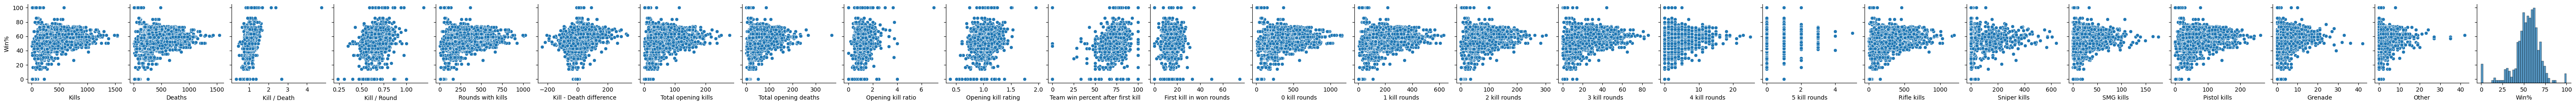

In [37]:
sns.pairplot(stats_win, y_vars="Win%")

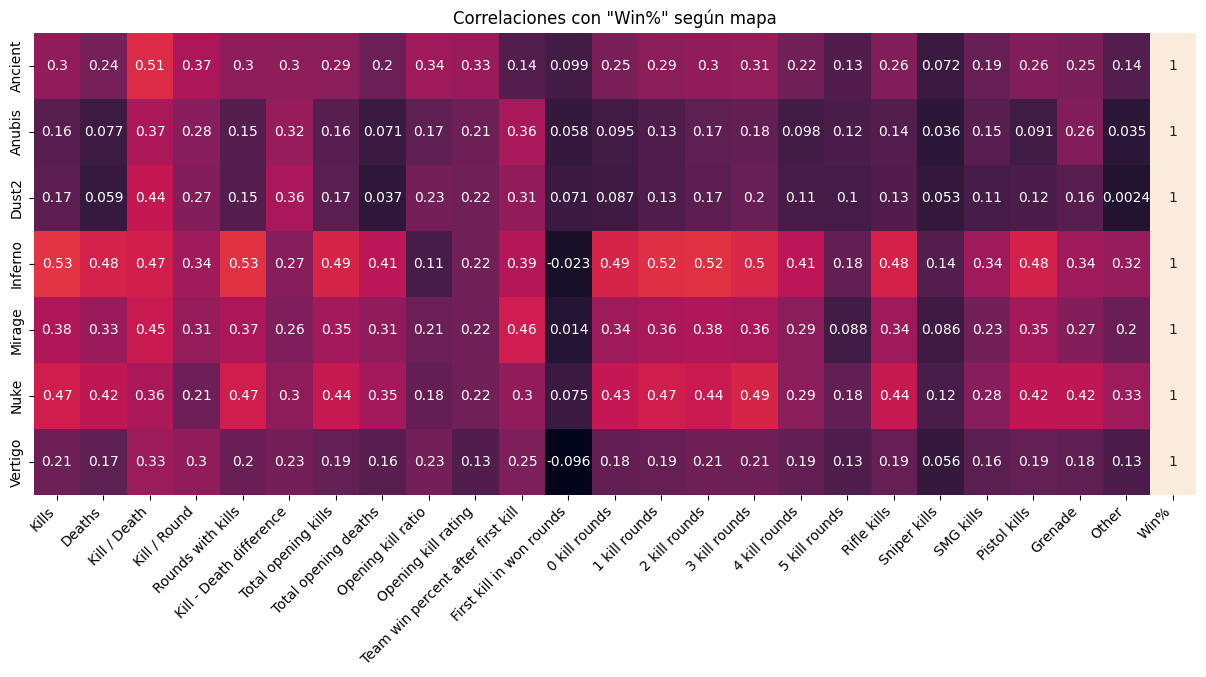

In [38]:
maps = ['Ancient', 'Anubis', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Vertigo']
variables = list(stats_win.columns)
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa')

plt.xticks(rotation=45, ha='right')

plt.show()

Abrá algún cambio si filtramos ``Win percent`` a valores en (0, 100).

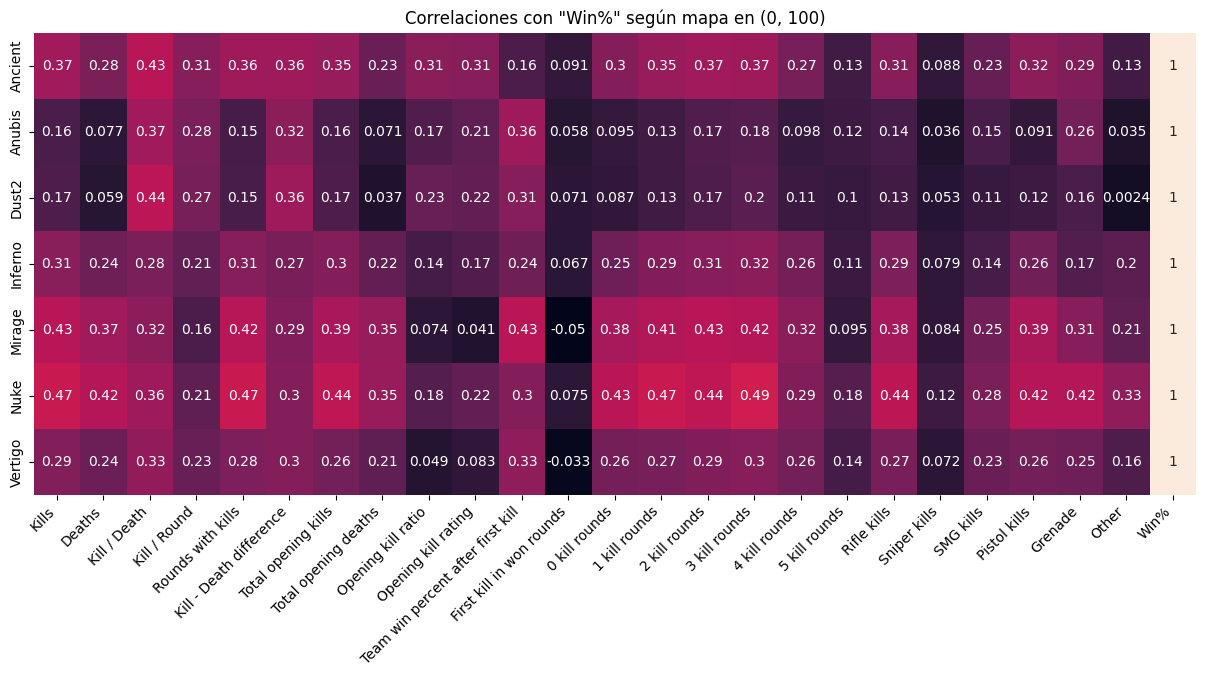

In [39]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Win%"] != 0]
    filtro = filtro[filtro["Win%"] != 100]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en (0, 100)')

plt.xticks(rotation=45, ha='right')

plt.show()

En los equipos, los jugadores tienen asignados diferentes roles. Uno de ellos es el "awper", caracterizado ser el jugador que lleva el arma "AWP" en las rondas. 

Definimos a un awper a aquellos jugadores con más de 150 Sniper kills. Veamos si hay algún cambio en las correlaciones, sobre todo en la variable ``Sniper kills``.

In [40]:
stats_win["Sniper kills"].quantile(.9)

np.float64(172.9000000000001)

<Axes: ylabel='Sniper kills'>

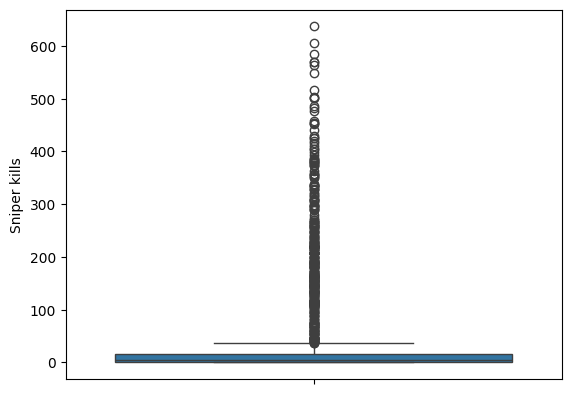

In [41]:
sns.boxplot(stats_win["Sniper kills"])

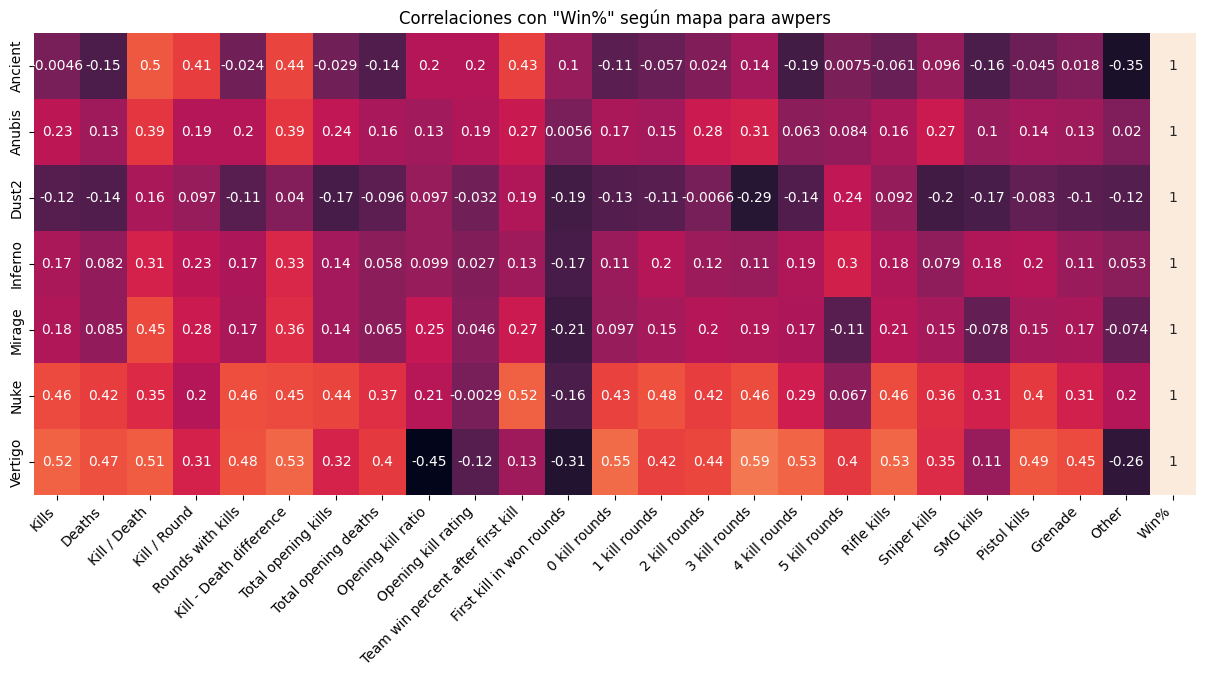

In [42]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Sniper kills"] >= 150]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa para awpers')

plt.xticks(rotation=45, ha='right')

plt.show()

Vemos que los awpers tiene más impacto en los mapas de Nuke y Vertigo.

## Win% y Team Stats

In [43]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


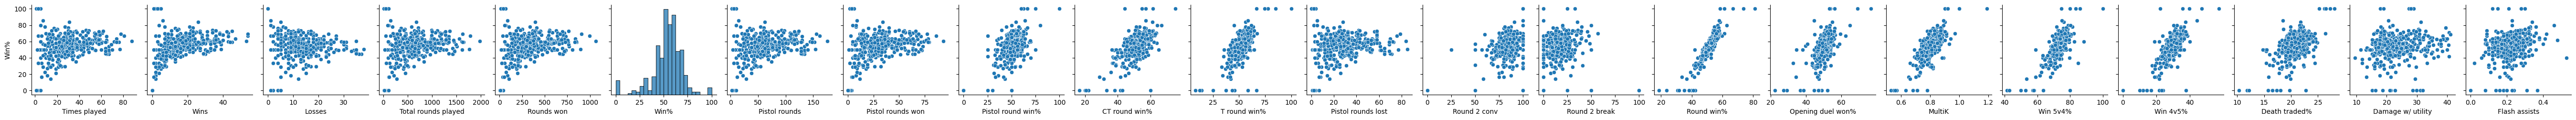

In [44]:
sns.pairplot(df_teams, y_vars="Win%")

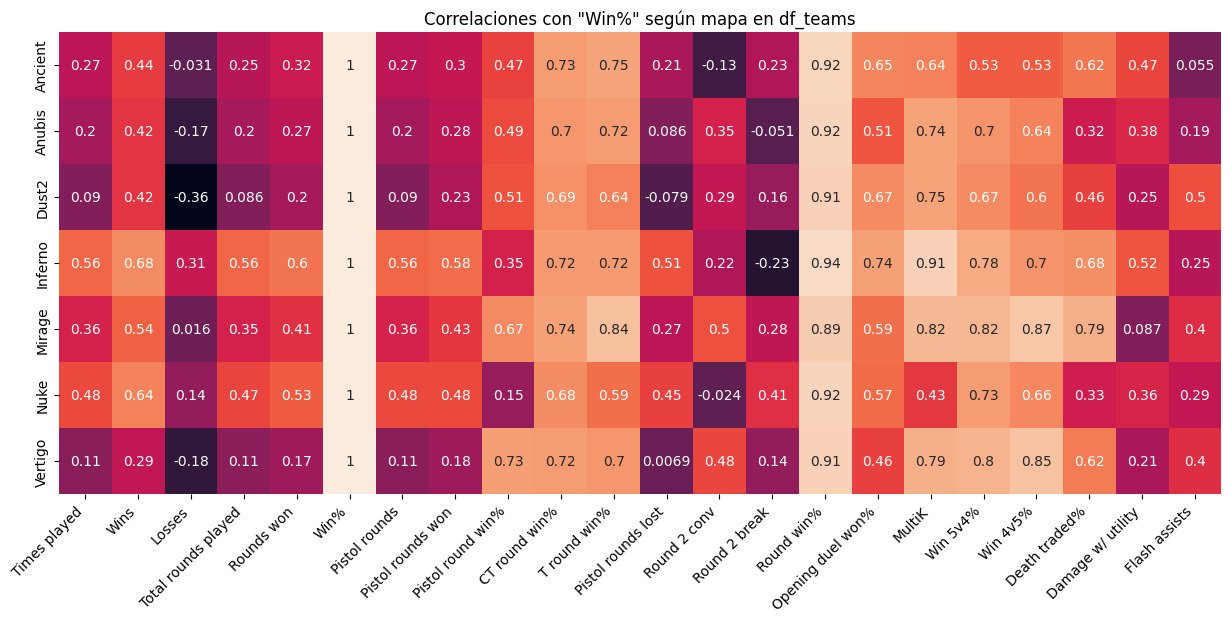

In [45]:
variables = list(df_teams.columns)
variables.remove("Team")
variables.remove("Group")
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = df_teams[df_teams["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en df_teams')

plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Modelos de predicción

## Métricas de equipo

Dadas las observaciones vistas en el EDA, integraremos las stats de los jugadores a DataFrame ``df_teams``, de manera de tener los datos más representativos en de los jugadores de un equipo en todos los mapas.

Vimos que hay ciertas stats que se correlacionan más que otras con el Win% de su equipo. Para integrarlas utilizaremos árboles de decisiones, pero no tan solo uno y arriesgarnos a producir un overfitting o a obtener malos resultados por el ruido, en cambio usaremos varios de ellos utilizando ``RandomForestRegressor`` que finalmente nos dirá cuales stats de los jugadores tienen más peso en el porcentaje de victorias del equipo.

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Separar variables predictoras (X) y variable objetivo (y)
X = stats_win.drop(columns=['Win%', 'Map Name'])
y = stats_win['Win%']

# Normalización con StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Crear modelo Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Validación cruzada con RMSE
scores = cross_val_score(rf_model, X_sc, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

rmse_scores = -scores

print("RMSE por partición:", rmse_scores)
print("Promedio de RMSE:", rmse_scores.mean())
print("Desviación estándar de RMSE:", rmse_scores.std())

RMSE por partición: [10.12047566 10.80118815 14.39159523 11.52437033 14.68540045]
Promedio de RMSE: 12.304605962801546
Desviación estándar de RMSE: 1.8795299687947835


In [47]:
def comparacion_stats_por_mapa(df: pd.DataFrame, titulo: str) -> pd.DataFrame:
    feature_importance_df = pd.DataFrame()
    for map_name in maps:
        filtro = df[df["Map Name"] == map_name]

        X = filtro.drop(columns=['Win%', 'Map Name'])
        y = filtro['Win%']

        rf_model.fit(X, y)

        # Importancia de características
        feature_importance_map = pd.DataFrame(rf_model.feature_importances_, columns=[map_name], index=X.columns)

        feature_importance_df = pd.concat([feature_importance_df, feature_importance_map], axis=1)

    df_melted = feature_importance_df.T.reset_index().melt(id_vars='index', var_name='Columna', value_name='Valor')
    df_melted.rename(columns={'index': 'Fila'}, inplace=True)
    df_melted

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Columna', y='Valor', hue='Fila', palette='Set1')

    plt.title(titulo, fontsize=16)
    plt.ylabel('Peso')
    plt.xlabel('Stat')
    plt.legend(title='Filas', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return feature_importance_df.T

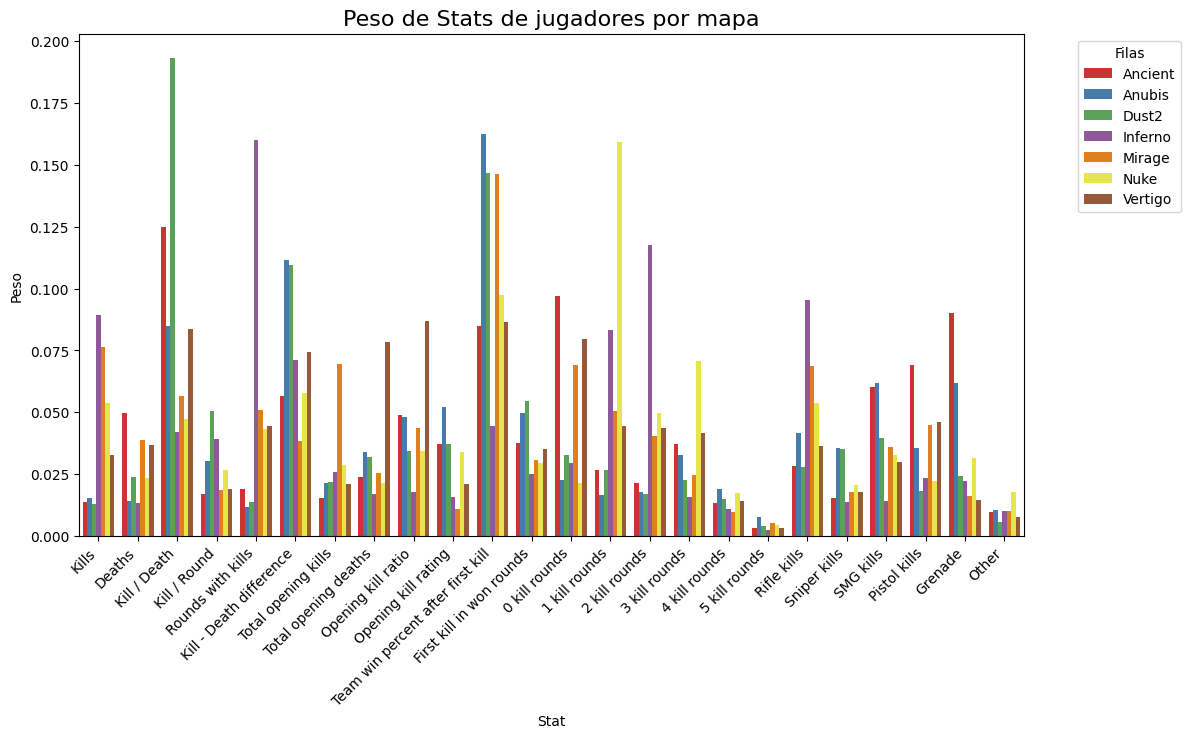

In [48]:
a = comparacion_stats_por_mapa(stats_win, "Peso de Stats de jugadores por mapa")

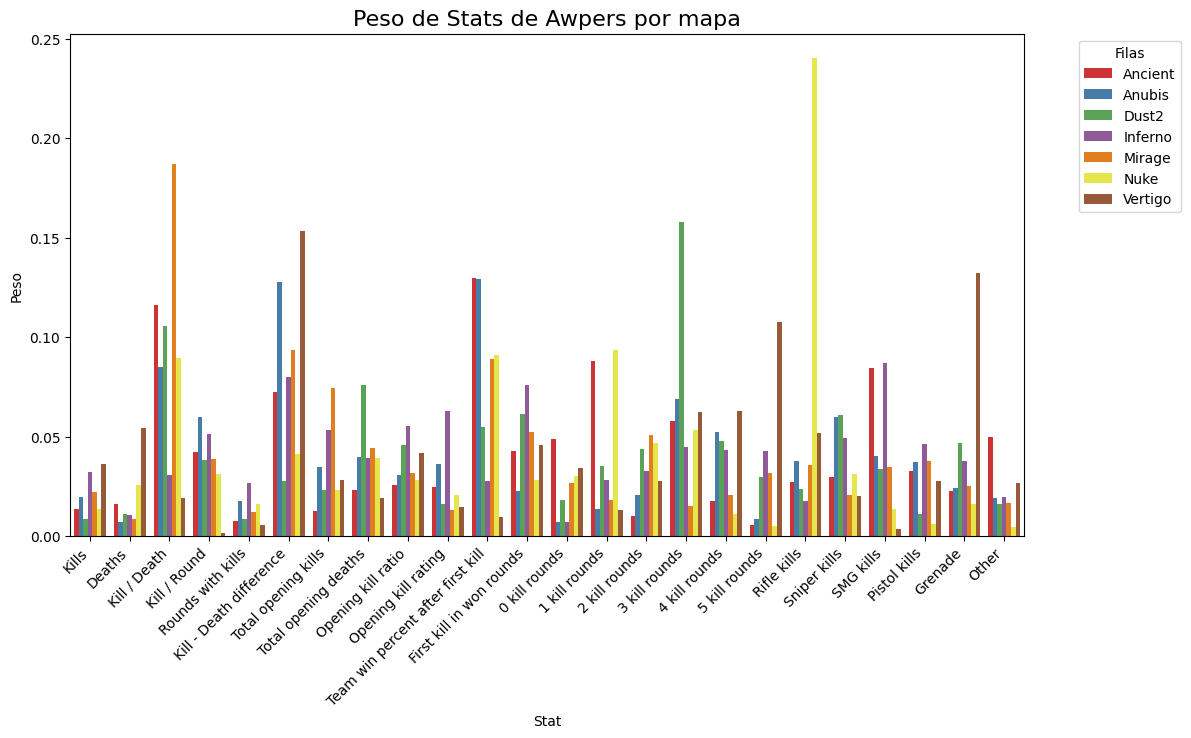

In [49]:
stats_awpers = stats_win[stats_win["Sniper kills"] >= 150]
peso_awpers = comparacion_stats_por_mapa(stats_awpers, "Peso de Stats de Awpers por mapa")

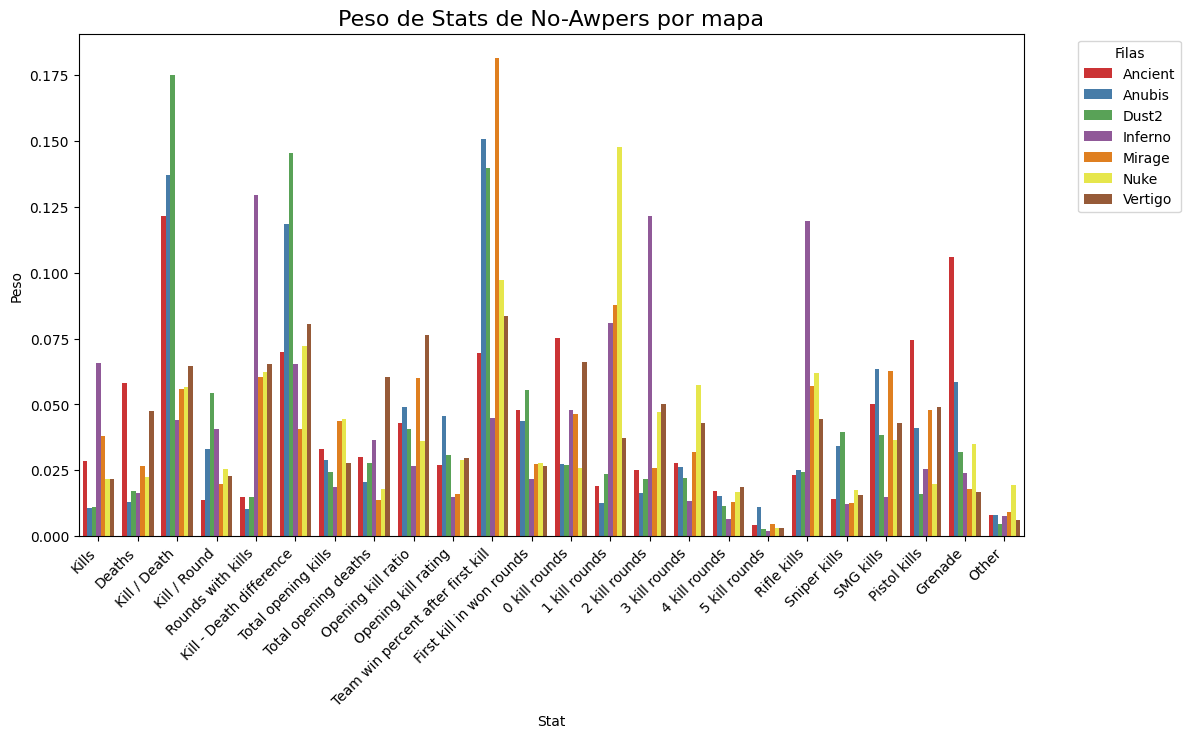

In [50]:
stats_not_awpers = stats_win[stats_win["Sniper kills"] <= 150]
pesos_not_awpers = comparacion_stats_por_mapa(stats_not_awpers, "Peso de Stats de No-Awpers por mapa")

Para integrar los datos de manera a ``df_team`` vamos a estandarizar los datos y luego calcular el valor del jugardor en 4 grupos diferentes, para así promediarlo con el de sus compañeros de equipo. 

In [51]:
df_players

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,18,15,1.20,0.86,13,3,3,0,0.00,1.38,...,13,0,3,2,0,0,salo-mux,asia_rmr,GR,Vertigo
1862,5,16,0.31,0.24,5,-11,1,3,0.33,0.67,...,2,2,0,1,0,0,weqt2,asia_rmr,GR,Vertigo
1863,12,14,0.86,0.57,7,-2,0,2,0.00,0.51,...,8,0,0,3,2,1,mediocrity,asia_rmr,GR,Vertigo
1864,15,17,0.88,0.71,7,-2,4,3,1.33,1.38,...,11,0,0,2,2,0,runnin,asia_rmr,GR,Vertigo


In [52]:
from sklearn.preprocessing import StandardScaler

awpers = df_players[df_players["Sniper kills"] >= 150]
non_awpers = df_players[df_players["Sniper kills"] < 150]

def normalizar_stats(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=["number"])
    non_numeric_columns = df.select_dtypes(exclude=["number"])

    scaler = StandardScaler()
    numeric_columns_normalized = scaler.fit_transform(numeric_columns)

    stats_normalized = non_numeric_columns.copy()
    stats_normalized[numeric_columns.columns] = numeric_columns_normalized
    return stats_normalized

awpers_normalized     = normalizar_stats(awpers)
non_awpers_normalized = normalizar_stats(non_awpers)

In [53]:
Overall_stats = ['Kills', 'Deaths', 'Kill / Death', 'Kill / Round', 'Rounds with kills', 'Kill - Death difference']
Opening_stats = ['Total opening kills', 'Total opening deaths', 'Opening kill ratio', 'Opening kill rating', 'Team win percent after first kill', 'First kill in won rounds']
Round_stats = ['0 kill rounds', '1 kill rounds', '2 kill rounds', '3 kill rounds', '4 kill rounds', '5 kill rounds']
Weapon_stats = ['Rifle kills', 'Sniper kills', 'SMG kills', 'Pistol kills', 'Grenade', 'Other']

def stats_with_weight(df: pd.DataFrame) -> pd.DataFrame:
    df_final = pd.DataFrame()
    for map_name in maps:
        stats_map = df[df["Map Name"] == map_name].copy()
        weight_map = peso_awpers.loc[map_name]

        stats_map["Overall Stats"] = stats_map[Overall_stats].dot(weight_map[Overall_stats])
        stats_map["Opening Stats"] = stats_map[Opening_stats].dot(weight_map[Opening_stats])
        stats_map["Round Stats"] = stats_map[Round_stats].dot(weight_map[Round_stats])
        stats_map["Weapon Stats"] = stats_map[Weapon_stats].dot(weight_map[Weapon_stats])

        df_final = pd.concat([df_final, stats_map])
    
    return df_final

awpers = stats_with_weight(awpers_normalized)
non_awpers = stats_with_weight(non_awpers_normalized)

In [54]:
a = pd.concat([awpers, non_awpers])
a = a.groupby(["Team", "Map Name"], observed=False)[["Overall Stats", "Opening Stats", "Round Stats", "Weapon Stats"]].mean()

In [55]:
df_teams = df_teams.merge(a.reset_index(), on=['Team', 'Map Name'], how='inner')
df_teams

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists,Overall Stats,Opening Stats,Round Stats,Weapon Stats
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,0.81,74.4,30.3,19.9,20.9,0.27,0.047609,0.028320,0.043849,0.003501
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,0.87,74.8,30.6,22.9,28.0,0.34,0.067904,0.053050,-0.045235,-0.034949
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,0.86,73.8,34.1,20.4,24.2,0.23,0.093815,0.023704,0.074244,0.068356
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,0.79,70.8,26.5,16.9,26.0,0.22,-0.130443,-0.265945,-0.195829,-0.183053
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,0.80,74.8,31.5,21.0,23.1,0.18,-0.067155,0.019008,0.154079,0.146061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,asia_rmr,FlyQuest,Vertigo,11,7,4,245,139,63.6,22,...,0.94,73.7,36.6,22.2,40.1,0.41,0.096782,0.024479,0.011461,0.057156
359,asia_rmr,Lynn Vision,Vertigo,7,2,5,150,72,28.6,14,...,0.81,63.2,32.4,20.5,21.8,0.20,-0.167931,-0.081172,-0.289326,-0.235570
360,asia_rmr,Rare Atom,Vertigo,12,7,5,254,134,58.3,24,...,0.85,74.4,31.8,19.2,31.1,0.22,-0.120208,-0.041093,-0.212200,-0.218103
361,asia_rmr,TALON,Vertigo,8,4,4,180,92,50.0,16,...,0.81,69.9,31.0,24.2,28.7,0.24,0.046649,0.043056,-0.036773,-0.064031


In [56]:
from scipy.stats import pearsonr

c1 = pearsonr(df_teams["Overall Stats"], df_teams["Win%"])
c2 = pearsonr(df_teams["Opening Stats"], df_teams["Win%"])
c3 = pearsonr(df_teams["Round Stats"], df_teams["Win%"])
c4 = pearsonr(df_teams["Weapon Stats"], df_teams["Win%"])

print(f"Correlación entre métrica del equipo y victorias: {c1[0]}, {c2[0]}, {c3[0]}, {c4[0]}")

Correlación entre métrica del equipo y victorias: 0.6805074094635178, 0.43468885663366996, 0.2919020829406075, 0.31531453078512706


## Prueba de Modelos

Como nuestro objetivo es predecir quien ganará un enfrentamiento entre dos equipos, hay que entrenar un modelo que, al pasarle dos equipos, nos de la probabilidad de que un equipo le gane al otro para cada uno de los 7 mapas.

In [57]:
df_complete = pd.merge(df_matches, df_teams, how="left", left_on=["Team", "Map Name"], right_on=["Team", "Map Name"])
df_complete = pd.merge(df_complete, df_teams, how="left", left_on=["Opponent", "Map Name"], right_on=["Team", "Map Name"])

df_complete = df_complete.drop(["Team_y"], axis=1)
df_complete = df_complete.rename({
    "Opponent": "Team_y"
}, axis=1)

In [58]:
maps_encoded = pd.get_dummies(df_complete['Map Name'], prefix='Map')
df = pd.concat([df_complete, maps_encoded], axis=1)
df = df.drop(columns=['Map Name'])
df

,Date,Team_x,Team_y,Result RW,Result RL,W/L,Result Diff,Group_x,Times played_x,Wins_x,...,Opening Stats_y,Round Stats_y,Weapon Stats_y,Map_Ancient,Map_Anubis,Map_Dust2,Map_Inferno,Map_Mirage,Map_Nuke,Map_Vertigo
0,2024-11-19,Natus Vincere,SAW,13,2,1,11,europa_1,34.0,22.0,...,0.006640,0.123655,0.087460,True,False,False,False,False,False,False
1,2024-11-19,Natus Vincere,SAW,13,10,1,3,europa_1,31.0,16.0,...,0.130764,0.312636,0.387372,False,False,False,False,False,True,False
2,2024-11-18,Natus Vincere,MOUZ,7,13,0,-6,europa_1,25.0,14.0,...,-0.059601,-0.064460,-0.101865,False,False,False,True,False,False,False
3,2024-11-18,Natus Vincere,MOUZ,8,13,0,-5,europa_1,17.0,13.0,...,-0.030939,-0.243586,-0.073067,False,False,True,False,False,False,False
4,2024-11-18,Natus Vincere,MOUZ,13,4,1,9,europa_1,38.0,27.0,...,0.056605,0.008718,-0.031685,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,2024-04-10,DRILLAS,GamerLegion,13,10,1,3,NaN,NaN,NaN,...,-0.043108,0.032285,0.015482,False,True,False,False,False,False,False
5862,2024-09-30,DRILLAS,TSM,8,13,0,-5,NaN,NaN,NaN,...,-0.004316,0.127765,0.157727,False,False,False,False,False,True,False
5863,2024-09-30,DRILLAS,TSM,11,13,0,-2,NaN,NaN,NaN,...,-0.052193,0.136814,0.098408,True,False,False,False,False,False,False
5864,2024-09-24,DRILLAS,Passion UA,16,14,1,2,NaN,NaN,NaN,...,0.320423,0.395987,0.374344,False,False,False,False,True,False,False


In [59]:
from sklearn.preprocessing import StandardScaler

df = df.drop(columns=["Date", "Team_x", "Team_y", "Result RW", "Result RL", "Group_x", "Group_y"])
df = df.dropna()

team_stats_columns = df.columns[2:24]
team_stats_columns = team_stats_columns.append(df.columns[28:-11])

scaler = StandardScaler()
df[team_stats_columns] = scaler.fit_transform(df[team_stats_columns])

Función para ver la matriz de confución y algunas métricas importantes

In [60]:
from sklearn import metrics

def metricas_importante(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="")
    plt.ylabel('Observado')
    plt.xlabel('Predicción')
    plt.title('Matriz de Confusión')

    rmse      = metrics.root_mean_squared_error(y_test, y_pred)
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    fscore    = metrics.f1_score(y_test, y_pred)

    print(f'RMSE:      {rmse:.2f}')
    print(f'Accuracy:  {accuracy:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F score:   {fscore:.2f}')

    report0 = metrics.classification_report(y_test, y_pred)
    print(report0)

### Regresión Logística

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.64
ROC AUC: 0.67


RMSE:      0.60
Accuracy:  0.64
Recall:    0.62
Precision: 0.64
F score:   0.63
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       584
           1       0.64      0.62      0.63       584

    accuracy                           0.64      1168
   macro avg       0.64      0.64      0.64      1168
weighted avg       0.64      0.64      0.64      1168



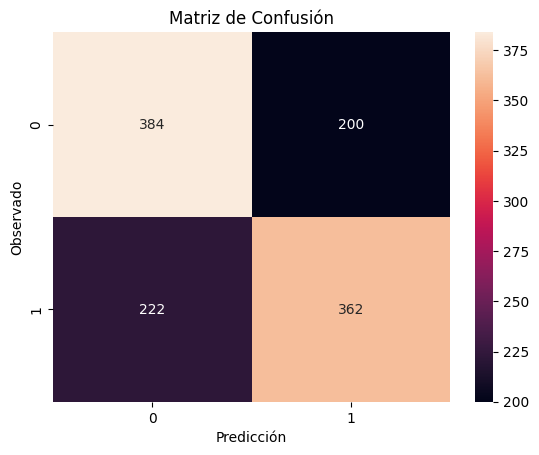

In [62]:
metricas_importante(y_test, y_pred)

### Regresión Lineal

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['Result Diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo
lineal_model = LinearRegression()
lineal_model.fit(X_train, y_train)

# Predicciones
y_pred = lineal_model.predict(X_test)

# Evaluar el modelo
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 5.55
R²: 0.12


### Clasificación con PCA y SCV

In [64]:
from sklearn.decomposition import PCA

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)

principal_Df = pd.DataFrame(principalComponents)

In [65]:
from sklearn.svm import SVC

X = principal_Df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# rbf = Gaussian Kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

RMSE:      0.62
Accuracy:  0.61
Recall:    0.58
Precision: 0.62
F score:   0.60
              precision    recall  f1-score   support

           0       0.61      0.64      0.63       584
           1       0.62      0.58      0.60       584

    accuracy                           0.61      1168
   macro avg       0.61      0.61      0.61      1168
weighted avg       0.61      0.61      0.61      1168



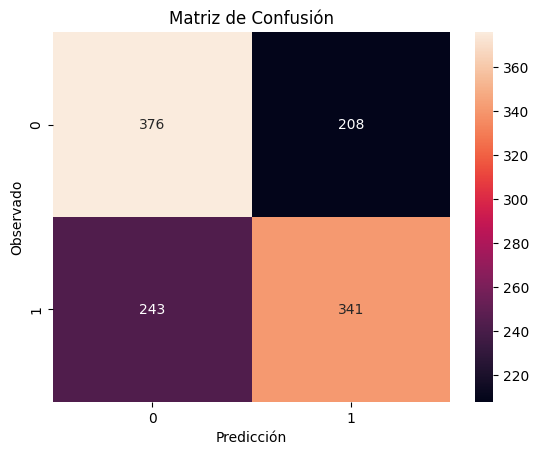

In [66]:
metricas_importante(y_test, y_pred)

### RandomForestRegressor

RMSE:      0.66
Accuracy:  0.56
Recall:    0.59
Precision: 0.56
F score:   0.57
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       584
           1       0.56      0.59      0.57       584

    accuracy                           0.56      1168
   macro avg       0.56      0.56      0.56      1168
weighted avg       0.56      0.56      0.56      1168



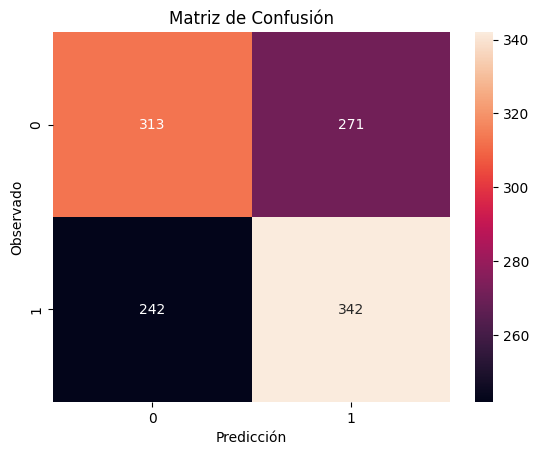

In [67]:
X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

y_pred = [round(i) for i in y_pred]
metricas_importante(y_test, y_pred)

### Clasificación Binaria - Label Encoding

Hasta el momento hemos probado modelos con dataframes que incluyen variables de tipo datetime, int, float y category. Ésta última podría estar influyendo significativamente en el resultado, por lo que experimentaremos de otro modo: Transformaremos las variables "category" en Label Encoding" para luego hacer una "Clasificación Binaria" (ya que el resultado que buscamos predecir es básicamente si "gana"o "pierde"), y ver qué resultados obtenemos.

Hacemos una copia de cada Dataframe de interés (ya que transformaremos las variables)

In [68]:
df_matches_copia = df_matches.copy()

In [69]:
df_teams_copia = df_teams.copy()

In [70]:
df_players_copia = df_players.copy()

Vemos la informacion de cada columna y sus similitudes:

In [71]:
df_matches_copia.columns

Index(['Date', 'Team', 'Opponent', 'Map Name', 'Result RW', 'Result RL', 'W/L',
       'Result Diff'],
      dtype='object')

In [72]:
df_players_copia.columns

Index(['Kills', 'Deaths', 'Kill / Death', 'Kill / Round', 'Rounds with kills',
       'Kill - Death difference', 'Total opening kills',
       'Total opening deaths', 'Opening kill ratio', 'Opening kill rating',
       'Team win percent after first kill', 'First kill in won rounds',
       '0 kill rounds', '1 kill rounds', '2 kill rounds', '3 kill rounds',
       '4 kill rounds', '5 kill rounds', 'Rifle kills', 'Sniper kills',
       'SMG kills', 'Pistol kills', 'Grenade', 'Other', 'Player', 'Group',
       'Team', 'Map Name'],
      dtype='object')

In [73]:
df_players_copia.columns

Index(['Kills', 'Deaths', 'Kill / Death', 'Kill / Round', 'Rounds with kills',
       'Kill - Death difference', 'Total opening kills',
       'Total opening deaths', 'Opening kill ratio', 'Opening kill rating',
       'Team win percent after first kill', 'First kill in won rounds',
       '0 kill rounds', '1 kill rounds', '2 kill rounds', '3 kill rounds',
       '4 kill rounds', '5 kill rounds', 'Rifle kills', 'Sniper kills',
       'SMG kills', 'Pistol kills', 'Grenade', 'Other', 'Player', 'Group',
       'Team', 'Map Name'],
      dtype='object')

In [74]:
label_encoders_1 = {}
label_encoders_2 = {}
label_encoders_3 = {}

In [75]:
# Transformación de variables category a label encoding - df_matches_copia
columns_to_label_encoding = ["Team", "Opponent", "Map Name"]

for col in columns_to_label_encoding:
    lab = LabelEncoder()
    df_matches_copia[col] = lab.fit_transform(df_matches_copia[col])
    label_encoders_1[col] = lab  

In [76]:
# Transformación de variables category a label encoding - df_teams_copia
columns_to_label_encoding = ["Group", "Team", "Map Name"]

for col in columns_to_label_encoding:
    lab = LabelEncoder()
    df_teams_copia[col] = lab.fit_transform(df_teams_copia[col])
    label_encoders_2[col] = lab  

In [77]:
# Transformación de variables category a label encoding - df_players_copia
columns_to_label_encoding = ["Player", "Group", "Team", "Map Name"]

for col in columns_to_label_encoding:
    lab = LabelEncoder()
    df_players_copia[col] = lab.fit_transform(df_players_copia[col])
    label_encoders_3[col] = lab

En base a las columnas que comparten y son de interés, hacemos "merge" a los Dataframes y los analizamos:

In [78]:
# Matches y teams

df_combinado_1 = pd.merge(df_matches_copia, df_teams_copia, on=["Team", "Map Name"], how="left")
df_combinado_1

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff,Group,Times played,...,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists,Overall Stats,Opening Stats,Round Stats,Weapon Stats
0,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,0.85,75.5,33.9,21.7,29.6,0.25,0.172669,0.087635,0.565012,0.426300
1,2024-11-19,33,42,5,13,10,1,3,2.0,14.0,...,0.78,66.2,29.7,19.0,20.5,0.07,-0.093888,-0.174363,-0.218592,-0.254624
2,2024-11-18,33,32,3,7,13,0,-6,2.0,33.0,...,0.74,69.3,26.6,19.8,38.0,0.26,-0.101378,-0.006315,0.007533,0.094541
3,2024-11-18,33,32,2,8,13,0,-5,2.0,19.0,...,0.80,72.3,34.1,20.0,24.1,0.32,-0.060545,-0.059204,-0.163511,-0.078633
4,2024-11-18,33,32,4,13,4,1,9,2.0,26.0,...,0.86,75.1,27.8,19.5,20.5,0.17,-0.057209,0.001841,-0.044903,-0.043939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,2024-04-10,14,23,1,13,10,1,3,2.0,61.0,...,0.83,73.8,29.4,23.9,21.5,0.16,0.209231,0.117566,0.238812,0.228836
5862,2024-09-30,14,48,5,8,13,0,-5,2.0,60.0,...,0.81,72.3,26.2,20.1,14.3,0.10,0.035739,0.078674,0.351226,0.401411
5863,2024-09-30,14,48,0,11,13,0,-2,2.0,48.0,...,0.85,74.6,28.9,21.5,21.1,0.22,0.096164,0.055746,0.196068,0.205993
5864,2024-09-24,14,38,4,16,14,1,2,2.0,65.0,...,0.85,70.9,34.2,20.3,17.1,0.17,0.239955,0.167101,0.243485,0.217698


In [79]:
# Matches y players:

df_combinado_2 = pd.merge(df_matches_copia, df_players_copia, on = ["Team", "Map Name"], how="left")
df_combinado_2

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff,Kills,Deaths,...,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group
0,2024-11-19,33,42,0,13,2,1,11,1296.0,1156.0,...,18.0,2.0,1007.0,6.0,74.0,194.0,17.0,6.0,247.0,2.0
1,2024-11-19,33,42,0,13,2,1,11,1137.0,1185.0,...,9.0,0.0,820.0,3.0,107.0,193.0,15.0,9.0,0.0,2.0
2,2024-11-19,33,42,0,13,2,1,11,1192.0,1190.0,...,15.0,1.0,908.0,12.0,77.0,184.0,18.0,9.0,190.0,2.0
3,2024-11-19,33,42,0,13,2,1,11,1200.0,1039.0,...,13.0,2.0,371.0,585.0,44.0,184.0,19.0,12.0,117.0,2.0
4,2024-11-19,33,42,0,13,2,1,11,776.0,670.0,...,9.0,1.0,620.0,7.0,22.0,121.0,3.0,9.0,262.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26776,2024-09-24,14,38,6,13,6,1,7,90.0,116.0,...,1.0,0.0,60.0,0.0,12.0,16.0,2.0,0.0,119.0,2.0
26777,2024-09-24,14,38,6,13,6,1,7,86.0,93.0,...,0.0,0.0,52.0,0.0,15.0,19.0,0.0,0.0,24.0,2.0
26778,2024-09-24,14,38,6,13,6,1,7,134.0,144.0,...,1.0,0.0,75.0,22.0,11.0,27.0,0.0,0.0,74.0,2.0
26779,2024-09-24,14,38,6,13,6,1,7,168.0,177.0,...,3.0,1.0,129.0,2.0,9.0,28.0,0.0,1.0,163.0,2.0


In [80]:
# (Matches - Teams) + Players

df_combinado = pd.merge(df_combinado_1, df_players_copia, on=["Team", "Map Name"], how="left")
df_combinado

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff,Group_x,Times played,...,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group_y
0,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,18.0,2.0,1007.0,6.0,74.0,194.0,17.0,6.0,247.0,2.0
1,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,9.0,0.0,820.0,3.0,107.0,193.0,15.0,9.0,0.0,2.0
2,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,15.0,1.0,908.0,12.0,77.0,184.0,18.0,9.0,190.0,2.0
3,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,13.0,2.0,371.0,585.0,44.0,184.0,19.0,12.0,117.0,2.0
4,2024-11-19,33,42,0,13,2,1,11,2.0,81.0,...,9.0,1.0,620.0,7.0,22.0,121.0,3.0,9.0,262.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26776,2024-09-24,14,38,6,13,6,1,7,2.0,9.0,...,1.0,0.0,60.0,0.0,12.0,16.0,2.0,0.0,119.0,2.0
26777,2024-09-24,14,38,6,13,6,1,7,2.0,9.0,...,0.0,0.0,52.0,0.0,15.0,19.0,0.0,0.0,24.0,2.0
26778,2024-09-24,14,38,6,13,6,1,7,2.0,9.0,...,1.0,0.0,75.0,22.0,11.0,27.0,0.0,0.0,74.0,2.0
26779,2024-09-24,14,38,6,13,6,1,7,2.0,9.0,...,3.0,1.0,129.0,2.0,9.0,28.0,0.0,1.0,163.0,2.0


Hacemos una copia de df_combinado para hacer un testeo previo

In [81]:
df_combinado_copia = df_combinado.copy()

In [82]:
# Eliminamos las columnas que no nos sirven:

columnas_a_eliminar = ["Date","Result RW", "Result RL", "Group_x", "Group_y"]
df_combinado_copia = df_combinado.drop(columns=columnas_a_eliminar)

In [83]:
X = df_combinado_copia.drop(columns=["Pistol rounds won","W/L",'Result Diff'])
y = df_combinado_copia["W/L"]

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
import xgboost as xgb

# Crea el modelo:
model_combinado = xgb.XGBClassifier (eval_metric="logloss",  random_state=42)
model_combinado.fit(X_train, y_train)

y_pred = model_combinado.predict(X_test)

In [86]:
from sklearn.metrics import accuracy_score, classification_report

# Predicciones:
y_pred = model_combinado.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2714
           1       0.74      0.76      0.75      2643

    accuracy                           0.75      5357
   macro avg       0.75      0.75      0.75      5357
weighted avg       0.75      0.75      0.75      5357



Como observamos, tenemos mayor % de precisión, por lo que haremos una reconversión de las variables, para poder usar el predictor:

In [104]:
# Funcion complementaria para utilizar junto con match_predictor: 

def revertir_label_encoding(df, columnas_a_revertir, diccionario):
    for col in columnas_a_revertir:
        if col in diccionario:
            try:
                encoder = diccionario[col]
                df[col] = encoder.inverse_transform(df[col])
            except:
                print("Error de reconversión")
                df[col] = df[col]      
    return df

In [99]:
df_combinado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26781 entries, 0 to 26780
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               26781 non-null  datetime64[ns]
 1   Team                               26781 non-null  int64         
 2   Opponent                           26781 non-null  object        
 3   Map Name                           26781 non-null  object        
 4   Result RW                          26781 non-null  int64         
 5   Result RL                          26781 non-null  int64         
 6   W/L                                26781 non-null  int8          
 7   Result Diff                        26781 non-null  int64         
 8   Group_x                            26145 non-null  float64       
 9   Times played                       26145 non-null  float64       
 10  Wins                              

In [100]:
# Hacemos un nuevo diccionario:
diccionario_combinado = {**label_encoders_1, **label_encoders_3}

In [101]:
del(diccionario_combinado["Group"])

In [102]:
diccionario_combinado

{'Team': LabelEncoder(),
 'Opponent': LabelEncoder(),
 'Map Name': LabelEncoder(),
 'Player': LabelEncoder()}

Luego trabajamos con df_combinado_vo (reconversion de df_combinado):

In [105]:
df_combinado_vo = revertir_label_encoding(df_combinado, ["Team", "Opponent", "Map Name", "Player"], diccionario_combinado)
df_combinado_vo

Error de reconversión
Error de reconversión
Error de reconversión
Error de reconversión


,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff,Group_x,Times played,...,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group_y
0,2024-11-19,33,SAW,Ancient,13,2,1,11,2.0,81.0,...,18.0,2.0,1007.0,6.0,74.0,194.0,17.0,6.0,247.0,2.0
1,2024-11-19,33,SAW,Ancient,13,2,1,11,2.0,81.0,...,9.0,0.0,820.0,3.0,107.0,193.0,15.0,9.0,0.0,2.0
2,2024-11-19,33,SAW,Ancient,13,2,1,11,2.0,81.0,...,15.0,1.0,908.0,12.0,77.0,184.0,18.0,9.0,190.0,2.0
3,2024-11-19,33,SAW,Ancient,13,2,1,11,2.0,81.0,...,13.0,2.0,371.0,585.0,44.0,184.0,19.0,12.0,117.0,2.0
4,2024-11-19,33,SAW,Ancient,13,2,1,11,2.0,81.0,...,9.0,1.0,620.0,7.0,22.0,121.0,3.0,9.0,262.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26776,2024-09-24,14,Passion UA,Vertigo,13,6,1,7,2.0,9.0,...,1.0,0.0,60.0,0.0,12.0,16.0,2.0,0.0,119.0,2.0
26777,2024-09-24,14,Passion UA,Vertigo,13,6,1,7,2.0,9.0,...,0.0,0.0,52.0,0.0,15.0,19.0,0.0,0.0,24.0,2.0
26778,2024-09-24,14,Passion UA,Vertigo,13,6,1,7,2.0,9.0,...,1.0,0.0,75.0,22.0,11.0,27.0,0.0,0.0,74.0,2.0
26779,2024-09-24,14,Passion UA,Vertigo,13,6,1,7,2.0,9.0,...,3.0,1.0,129.0,2.0,9.0,28.0,0.0,1.0,163.0,2.0


Con esta reconversión, podremos usar la función "match_predictor" en el siguiente item

# 4. Ganador del Major

El Major tiene el siguiente formato:

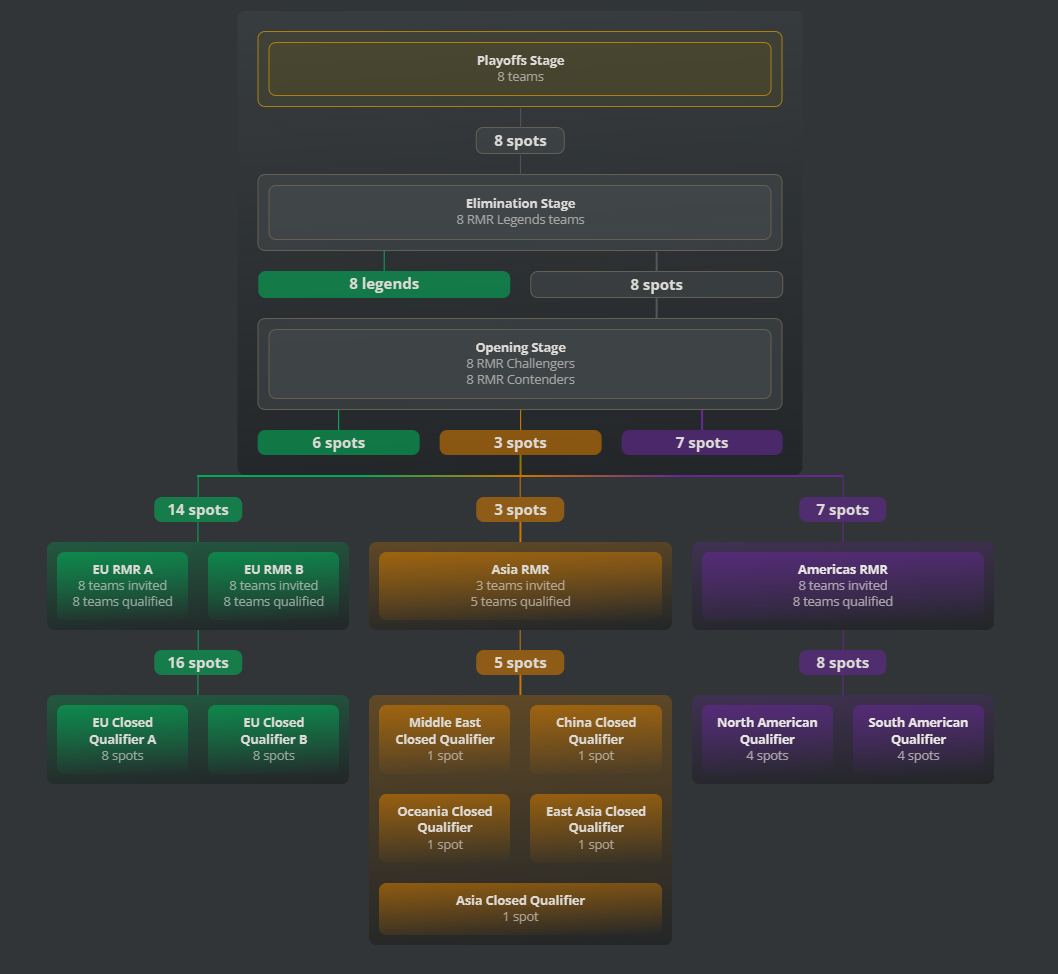

Actualmente ya pasaron las clasificatorias, así que nos enfocaremos en las 3 fases principales del evento

## Predictor entre dos equipos

In [93]:
def match_predictor(team_x: str, team_y: str) -> pd.DataFrame:
    maps = ["Ancient", "Anubis", "Dust2", "Inferno", "Mirage", "Nuke", "Vertigo"]

    # Filtra los equipos consultados
    team_x_stats = df_teams[df_teams["Team"] == team_x]
    team_y_stats = df_teams[df_teams["Team"] == team_y]

    # Los juntamos en uno solo    
    team_stats = pd.merge(team_x_stats, team_y_stats, how="outer", on="Map Name")

    # Falta algun mapa
    missing_maps = []
    if len(maps) != len(team_stats["Map Name"]):
        missing_maps = list(set(maps) - set(team_stats["Map Name"]))          

    # Obtenemos los índices donde faltan stats para algún equipo
    team_x_nan_rows = team_stats[team_stats["Team_x"].isna()].index
    team_x_nan_rows = team_x_nan_rows.to_list()
    team_y_nan_rows = team_stats[team_stats["Team_y"].isna()].index
    team_y_nan_rows = team_y_nan_rows.to_list()

    # Le damos el formato utilizado para entrenarlo
    maps_encoded = pd.get_dummies(team_stats['Map Name'], prefix='Map')
    team_stats = pd.concat([team_stats, maps_encoded], axis=1)
    team_stats = team_stats.drop(columns=['Map Name'])

    team_stats = team_stats.drop(columns=["Team_x", "Team_y", "Group_x", "Group_y"])
    team_stats = team_stats.dropna()

    team_stats_columns = team_stats.columns[:22]
    team_stats_columns = team_stats_columns.append(team_stats.columns[26:-11])
    team_stats_columns

    scaler = StandardScaler()
    team_stats[team_stats_columns] = scaler.fit_transform(team_stats[team_stats_columns])

    # Predecimos las probabilidades de que team_x gane usando el modelo escogido en la parte 3
    probs_x = lr_model.predict_proba(team_stats)[:, 1]
    probs_x = [round(i, 2) for i in probs_x]
    probs_y = [1-i for i in probs_x]

    # Los equipo que no tienen stats para algún mapa los tomaremos como que pierden el mapa
    for i in team_x_nan_rows:
        if i in team_y_nan_rows:
            probs_x.insert(i, 0)
            probs_y.insert(i, 0)
        else:
            probs_x.insert(i, 0)
            probs_y.insert(i, 1)

    for i in team_y_nan_rows:
        if i not in team_x_nan_rows:
            probs_x.insert(i, 1)
            probs_y.insert(i, 0)

    # Si ambos equipo no tienen stats en algún mapa ambas probs_x son 0
    if missing_maps:
        for map_name in missing_maps:
            probs_x.insert(maps.index(map_name), 0)
            probs_y.insert(maps.index(map_name), 0)

    # Crea un DataFrame con las probabilidades y retornamos
    df = pd.DataFrame({
        "Map": maps,
        team_x: probs_x,
        team_y: probs_y
    })
    return df

In [ ]:
match_predictor("The MongolZ", "Liquid")

,Map,The MongolZ,Liquid
0,Ancient,0.31,0.69
1,Anubis,0.25,0.75
2,Dust2,0.71,0.29
3,Inferno,0.66,0.34
4,Mirage,0.57,0.43
5,Nuke,0.43,0.57
6,Vertigo,0.00,0.00


In [ ]:
probs_df = match_predictor("Natus Vincere", "FaZe")
probs_df

,Map,Natus Vincere,FaZe
0,Ancient,0.43,0.57
1,Anubis,0.64,0.36
2,Dust2,0.84,0.16
3,Inferno,0.30,0.70
4,Mirage,0.37,0.63
5,Nuke,0.39,0.61
6,Vertigo,0.00,1.00


El funcionamiento de un partido profesional en CS2 tiene un sistema simple de baneo de mapas. Cuando se juega al mejor de 1 (BO1), el primer equipo banea 2 mapas, luego el segundo banea 3 y finalmente el primero decide que mapa jugar. Para los BO3, ambos equipos banean un mapa, luego ambos escogen uno para jugar, para después nuevamente banear uno cada equipo y desidor es el mapa de sobra.

Bajo esta lógica, se decidirá quién gana un partidos obteniendo las probabilidades luego de eliminar los mapas donde que sean más desfavorables para los equipos.

In [ ]:
def BO1(probs_df: pd.DataFrame) -> pd.DataFrame:
    for i in range(6):
        if i in [0, 1, 5]:
            n = probs_df.iloc[:, 1].idxmin()
            probs_df = probs_df.drop(index=n)
        else:
            n = probs_df.iloc[:, 2].idxmin()
            probs_df = probs_df.drop(index=n)

    return probs_df

def BO3(probs_df: pd.DataFrame) -> pd.DataFrame:
    df_temp = probs_df.copy()
    maps = []
    for i in range(7):
        team = i%2 + 1

        if i in [0,1,4,5]:
            n = df_temp.iloc[:, team].idxmin()
            df_temp = df_temp.drop(index=n)

        else:
            n = df_temp.iloc[:, team].idxmax()
            df_temp = df_temp.drop(index=n)
            maps.append(n)

    return probs_df.iloc[maps]

In [ ]:
BO1(probs_df)

,Map,Natus Vincere,FaZe
5,Nuke,0.39,0.61


In [ ]:
bo3 = BO3(probs_df)
bo3

,Map,Natus Vincere,FaZe
1,Anubis,0.64,0.36
3,Inferno,0.30,0.70
5,Nuke,0.39,0.61


In [ ]:
bo3.drop(columns="Map").mean().idxmax()

'FaZe'

Para ambos casos decimos que gana el que tenga un mejor promedio.

## Opening Stage

In [ ]:
class Team:
    def __init__(self, name: str) -> None:
        self.name = name
        self.wins = 0
        self.losses = 0

    def win(self):
        self.wins += 1

    def lose(self):
        self.losses += 1

    def __repr__(self):
        return f"{self.name} (V: {self.wins}, D: {self.losses})"

class Node:
    def __init__(self, wins, losses):
        self.wins = wins
        self.losses = losses
        self.teams = []

    def __repr__(self):
        return f"Nodo({self.wins}-{self.losses}, Equipos: {self.teams})"

class Standings:
    def __init__(self):
        self.nodes = {(w, l): Node(w, l) for w in range(4) for l in range(4)}
    
    def add_team(self, team):
        self.nodes[(0, 0)].teams.append(team)

    def match(self, team_x: Team, team_y: Team, BO1_: bool):
        results = match_predictor(team_x.name, team_y.name)

        if BO1_:
            winner_name = BO1(results).drop(columns="Map").mean().idxmax()
        else:
            winner_name = BO3(results).drop(columns="Map").mean().idxmax()

        if winner_name == team_x.name:
            winner = team_x
            loser = team_y
        else:
            winner = team_y
            loser = team_x

        self._move_team(winner, True)
        self._move_team(loser, False)

    def _move_team(self, team: Team, win: bool):
        # Eliminarlo del nodo actual
        nodo_actual = self.nodes[(team.wins, team.losses)]
        nodo_actual.teams.remove(team)

        # Actualizar Stats
        if win:
            team.win()
        else:
            team.lose()

        # Mover al nodo correspondiente
        new_node = self.nodes[(team.wins, team.losses)]
        new_node.teams.append(team)

    def final_results(self):
        for (w, l), node in sorted(self.nodes.items()):
            if node.teams:
                print(node)

    def simulate(self):
        round_1 = [(0,0)]
        round_2 = [(1,0), (0,1)]
        round_3_A = [(1,1), (0,2)]
        round_3_B = [(2,0)]
        round_4 = [(2,1), (1,2)]
        round_5 = [(2,2)]

        rounds = [round_1, round_2, round_3_A, round_3_B, round_4, round_5]

        for (w, l), node in (self.nodes.items()):
            for i, round_i in enumerate(rounds):
                if i <= 3:
                    bo1_ = True
                else:
                    bo1_ = False

                if (w, l) in round_i:
                    while node.teams:
                        team_x = node.teams[0]
                        team_y = node.teams[1]
                        self.match(team_x, team_y, bo1_)
                    
        self.final_results()

        qualified_teams = []
        for node in (self.nodes.values()):
            for team in node.teams:
                if team.wins == 3:
                    qualified_teams.append(team.name)

        return qualified_teams

In [ ]:
from random import shuffle

teams_opening = [
    "Wildcard",
    "MIBR",
    "paiN",
    "Complexity",
    "Liquid",
    "Imperial",
    "FURIA",
    "FlyQuest",
    "Rare Atom",
    "The MongolZ",

    "Spirit",
    "Passion UA",
    "GamerLegion",
    "fnatic",
    "FaZe",
    "G2",
]

shuffle(teams_opening)

opening_stage = Standings()
teams = [Team(team) for team in teams_opening]

for team in teams:
    opening_stage.add_team(team)

qualified_opening = opening_stage.simulate()
qualified_opening

Nodo(0-3, Equipos: [Rare Atom (V: 0, D: 3), The MongolZ (V: 0, D: 3)])
Nodo(1-3, Equipos: [Passion UA (V: 1, D: 3), Complexity (V: 1, D: 3), FaZe (V: 1, D: 3)])
Nodo(2-3, Equipos: [Spirit (V: 2, D: 3), FURIA (V: 2, D: 3), MIBR (V: 2, D: 3)])
Nodo(3-0, Equipos: [G2 (V: 3, D: 0), fnatic (V: 3, D: 0)])
Nodo(3-1, Equipos: [Wildcard (V: 3, D: 1), FlyQuest (V: 3, D: 1), Imperial (V: 3, D: 1)])
Nodo(3-2, Equipos: [paiN (V: 3, D: 2), GamerLegion (V: 3, D: 2), Liquid (V: 3, D: 2)])


['G2',
 'fnatic',
 'Wildcard',
 'FlyQuest',
 'Imperial',
 'paiN',
 'GamerLegion',
 'Liquid']

## Elimination Stage

In [ ]:
teams_leyends = [
    "Vitality",
    "MOUZ",
    "Natus Vincere",
    "Cloud9",
    "BIG",
    "3DMAX",
    "HEROIC",
    "Virtus.pro",
]

teams_leyends.extend(qualified_opening)
shuffle(teams_leyends)

elimination_stage = Standings()
teams = [Team(team) for team in teams_leyends]

for team in teams:
    elimination_stage.add_team(team)

qualified_elimination = elimination_stage.simulate()
qualified_elimination

Nodo(0-3, Equipos: [Virtus.pro (V: 0, D: 3), paiN (V: 0, D: 3)])
Nodo(1-3, Equipos: [Liquid (V: 1, D: 3), Vitality (V: 1, D: 3), Natus Vincere (V: 1, D: 3)])
Nodo(2-3, Equipos: [Wildcard (V: 2, D: 3), GamerLegion (V: 2, D: 3), MOUZ (V: 2, D: 3)])
Nodo(3-0, Equipos: [BIG (V: 3, D: 0), 3DMAX (V: 3, D: 0)])
Nodo(3-1, Equipos: [HEROIC (V: 3, D: 1), FlyQuest (V: 3, D: 1), G2 (V: 3, D: 1)])
Nodo(3-2, Equipos: [Cloud9 (V: 3, D: 2), Imperial (V: 3, D: 2), fnatic (V: 3, D: 2)])


['BIG', '3DMAX', 'HEROIC', 'FlyQuest', 'G2', 'Cloud9', 'Imperial', 'fnatic']

## Playoffs Stage

# 5. Limitaciones del modelo

Durante el proceso de selección de datos y del modelo se hicieron alguno supuestos y se dejaron de lado estadísticas importantes de los equipos por simplicidad del modelo.

Cosas que argumentar: https://github.com/ValveSoftware/counter-strike_regional_standings